In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Clone the DeepReg repository which contains the code
! git clone https://github.com/DeepRegNet/DeepReg
%cd ./DeepReg/
# Switch to a fixed version
! git checkout tags/miccai2020-challenge
# pip install into the notebook env
! pip install -e . --no-cache-dir
print(os.getcwd())

!pip install SimpleITK

Cloning into 'DeepReg'...
remote: Enumerating objects: 17178, done.
remote: Counting objects: 100% (1437/1437), done.
remote: Compressing objects: 100% (530/530), done.
remote: Total 17178 (delta 1032), reused 1245 (delta 907), pack-reused 15741
Receiving objects: 100% (17178/17178), 30.36 MiB | 28.92 MiB/s, done.
Resolving deltas: 100% (12389/12389), done.
/content/DeepReg
Note: switching to 'tags/miccai2020-challenge'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 47370db7 Merge pull request #390 from DeepR

In [3]:
import SimpleITK as sitk
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

import deepreg.model.layer as layer
import deepreg.model.loss.image as image_loss
import deepreg.model.loss.deform as deform_loss
import deepreg.model.layer_util as layer_util
import matplotlib.pyplot as plt
import os
import h5py
import numpy as np
import numpy.ma as ma
from tensorflow.keras.utils import get_file
import pandas as pd
import nibabel as nib 
import matplotlib.pyplot as plt

In [74]:
# Define registration parameters

# local normalised cross correlation loss between images
image_loss_name = "lncc" 

 # Loss to measure the bending energy of the ddf
deform_loss_name = "bending"
weight_deform_loss = 1 
learning_rate = 0.1

# Number of iterations of the model
total_iter = int(851) 

In [64]:
def dice_coefficient(y_true, y_pred, num_classes):
    dice = 0
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true, i), dtype=tf.float32)
        y_pred_i = tf.cast(tf.equal(y_pred, i), dtype=tf.float32)
        intersection = tf.reduce_sum(y_true_i * y_pred_i)
        union = tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i)
        dice += (2. * intersection + 1.) / (union + 1.)
    return dice / num_classes
dice_coefficient_multiclass(fixed_image_seg, moving_image_seg, 35)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6444668>

In [75]:
def train_step(warper, weights, optimizer, mov, fix, mov_seg, fix_seg, num_class):
    """
    Train step function for backpropagation using gradient tape.
    In contrast to CT function, we have a deformation regularisation.
    train_step(
            warping, var_ddf, optimiser, moving_image, fixed_image
        )
    :param warper: warping function returned from layer.Warping
    :param weights: trainable ddf [1, f_dim1, f_dim2, f_dim3, 3]
    :param optimizer: tf.optimizers
    :param mov: moving image [1, m_dim1, m_dim2, m_dim3]
    :param fix: fixed image [1, f_dim1, f_dim2, f_dim3]
    :return:
        loss: overall loss to optimise
        loss_image: image dissimilarity
        loss_deform: deformation regularisation
    """
    with tf.GradientTape() as tape:
        # Warp the moving image with the displacement field
        pred = warper(inputs=[weights, mov])

        # Warp the segmented moving image with the displacement field
        pred_seg = warper(inputs=[weights, mov_seg])

        # Calculate the image loss between the ground truth and prediction
        loss_image = image_loss.dissimilarity_fn(
            y_true=fix, y_pred=pred, name=image_loss_name)
        
        # Calculate the deformation loss
        loss_deform = deform_loss.local_displacement_energy(weights, deform_loss_name)

        # Calculate the dice coefficient for the segmened images
        loss_dice = 1 - tf.reduce_mean(dice_coefficient(pred_seg, fix_seg, num_class))

        # Apply mask to the images to mask background pixels
        mask_fix = ma.masked_equal(fix, 0) 
        mask_pred = ma.masked_equal(pred, 0) 

        # Calculate the MSE between the fixed image and warped moving image
        mse = np.square(np.subtract(mask_fix, mask_pred)).mean()

        # Total loss is weighted
        loss = loss_image + weight_deform_loss * loss_deform + loss_dice
    
    # Calculate the gradients by backpropagating the loss to the trainable layer
    gradients = tape.gradient(loss, [weights])
    
    # Apply the gradients using optimizer
    optimizer.apply_gradients(zip(gradients, [weights]))

    return loss, loss_image, loss_deform, mse, loss_dice

In [6]:
data_folder = '/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS'
validation_pairs = '/content/drive/MyDrive/Learn2Reg/OASIS/pairs_val_oasis.csv'

train_path = []
train_images = []

# Get a list of all subfolders from OASIS folder 
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]

# Iterate over each subfolder to get the preferred scan
for subfolder in subfolders:
    file_path = os.path.join(subfolder, 'aligned_norm.nii.gz')

    # Check if the file exists in the subfolder
    if os.path.isfile(file_path):
      train_path.append(file_path)

# print(train_path)

In [32]:
# Read the CSV file
pairs_df = pd.read_csv(validation_pairs)

# Iterate through the pairs and perform registration
deformation_fields = []
fixed_id_l = []
moving_id_l = []

Step 0 loss [-0.724499643] lncc [-0.724502265] bending [2.62588401e-06] mse 0.009168933991509694


<Figure size 640x480 with 0 Axes>

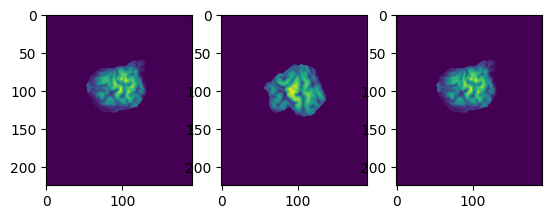

Step 50 loss [-0.769735873] lncc [-0.780851841] bending [0.0111159477] mse 0.007028928894021353


<Figure size 640x480 with 0 Axes>

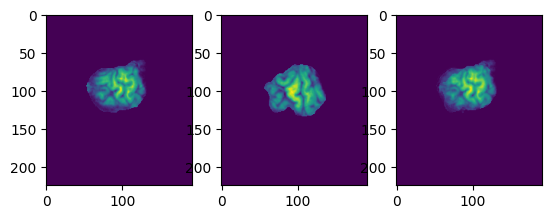

Step 100 loss [-0.801629126] lncc [-0.823967218] bending [0.0223381184] mse 0.005444344346559424


<Figure size 640x480 with 0 Axes>

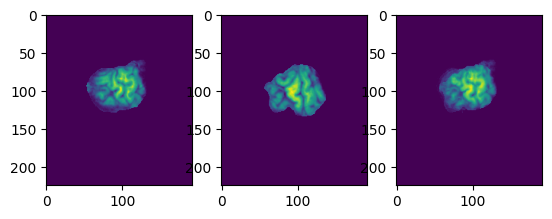

Step 150 loss [-0.823368788] lncc [-0.853855312] bending [0.0304865446] mse 0.004346852974758369


<Figure size 640x480 with 0 Axes>

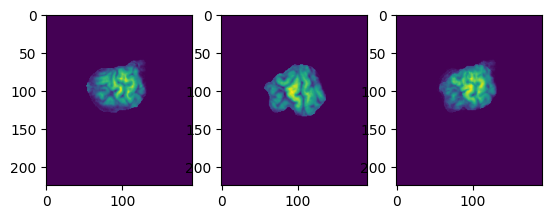

Step 200 loss [-0.837922931] lncc [-0.873673856] bending [0.0357509144] mse 0.0036235244590547937


<Figure size 640x480 with 0 Axes>

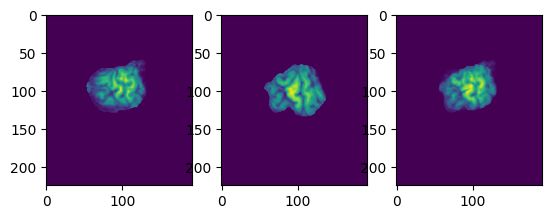

Step 250 loss [-0.847806096] lncc [-0.88673985] bending [0.0389337726] mse 0.003147119457025457


<Figure size 640x480 with 0 Axes>

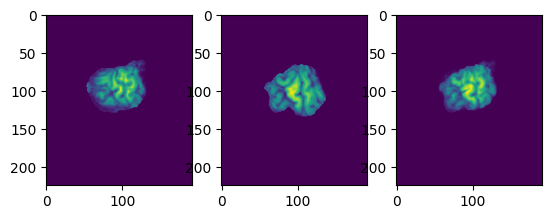

Step 0 loss [-0.734019399] lncc [-0.734022] bending [2.62653e-06] mse 0.011159529805179383


<Figure size 640x480 with 0 Axes>

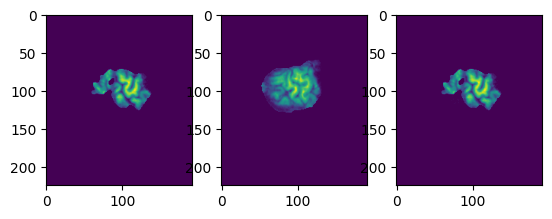

Step 50 loss [-0.776007235] lncc [-0.786017835] bending [0.0100105871] mse 0.00881779025560328


<Figure size 640x480 with 0 Axes>

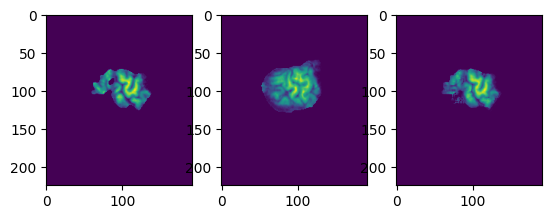

Step 100 loss [-0.805795729] lncc [-0.826329052] bending [0.0205333494] mse 0.006973021592287544


<Figure size 640x480 with 0 Axes>

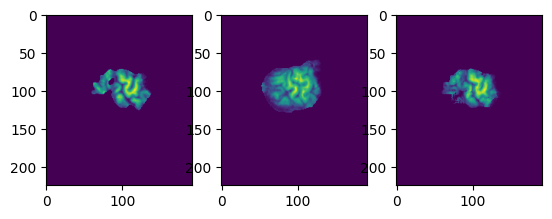

Step 150 loss [-0.825949848] lncc [-0.854101837] bending [0.028151961] mse 0.005706836048678527


<Figure size 640x480 with 0 Axes>

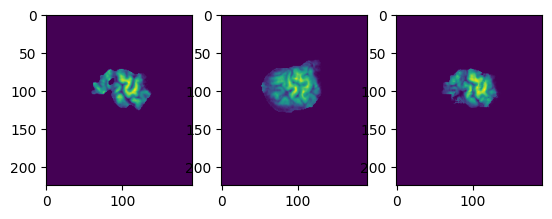

Step 200 loss [-0.83975929] lncc [-0.87311554] bending [0.0333562307] mse 0.004815449065732704


<Figure size 640x480 with 0 Axes>

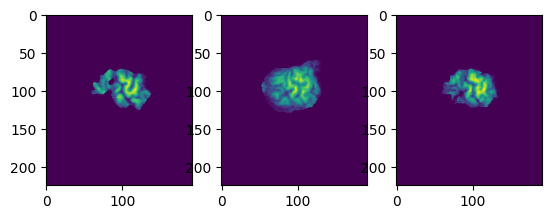

Step 250 loss [-0.849594235] lncc [-0.886559844] bending [0.0369656086] mse 0.004169559447950538


<Figure size 640x480 with 0 Axes>

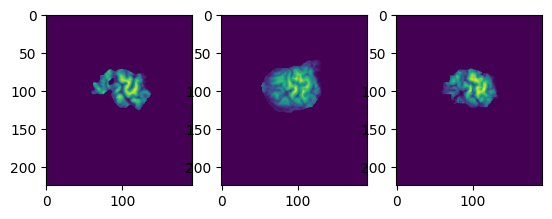

Step 0 loss [-0.737855494] lncc [-0.737858117] bending [2.62513822e-06] mse 0.012207628034482033


<Figure size 640x480 with 0 Axes>

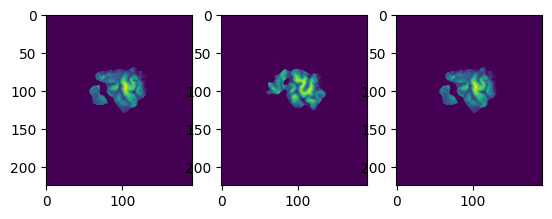

Step 50 loss [-0.780548751] lncc [-0.79054153] bending [0.00999279507] mse 0.009577607457529688


<Figure size 640x480 with 0 Axes>

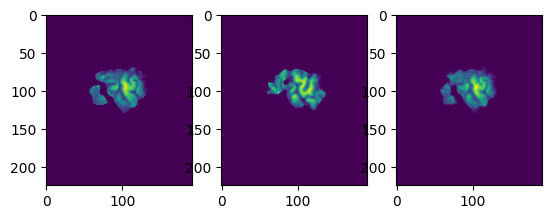

Step 100 loss [-0.810755432] lncc [-0.830939293] bending [0.0201838408] mse 0.007509725870671425


<Figure size 640x480 with 0 Axes>

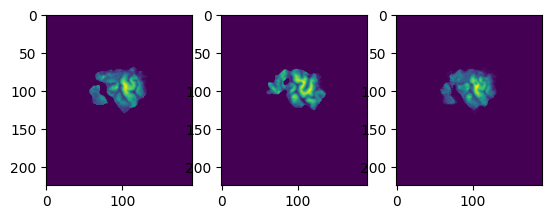

Step 150 loss [-0.831817567] lncc [-0.859610915] bending [0.0277933478] mse 0.006019200020859728


<Figure size 640x480 with 0 Axes>

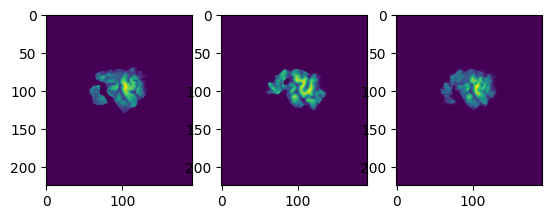

Step 200 loss [-0.846341848] lncc [-0.879262447] bending [0.0329206288] mse 0.004954326992997932


<Figure size 640x480 with 0 Axes>

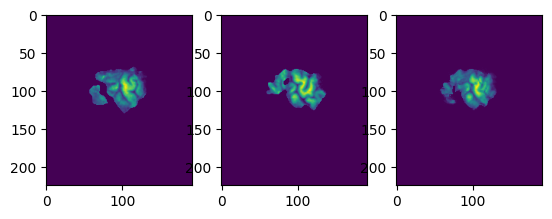

Step 250 loss [-0.856486082] lncc [-0.892607629] bending [0.0361215621] mse 0.00418079766961815


<Figure size 640x480 with 0 Axes>

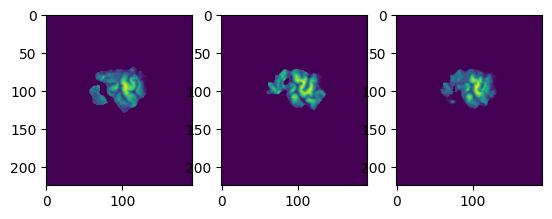

Step 0 loss [-0.728421688] lncc [-0.728424311] bending [2.62530648e-06] mse 0.0115543853559609


<Figure size 640x480 with 0 Axes>

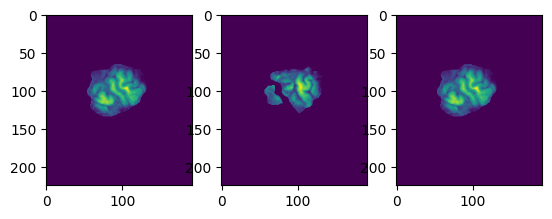

Step 50 loss [-0.76962781] lncc [-0.780067444] bending [0.0104396511] mse 0.00955285692509362


<Figure size 640x480 with 0 Axes>

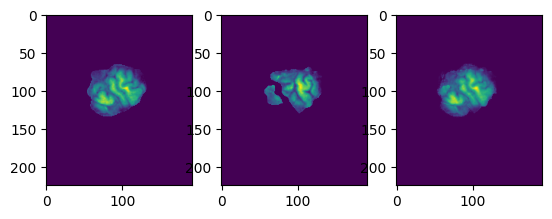

Step 100 loss [-0.799810231] lncc [-0.821022093] bending [0.0212118514] mse 0.00780064911067158


<Figure size 640x480 with 0 Axes>

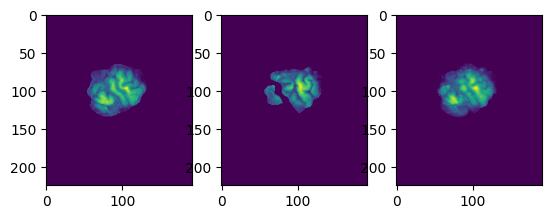

Step 150 loss [-0.82158041] lncc [-0.85098356] bending [0.0294031259] mse 0.00643941799326482


<Figure size 640x480 with 0 Axes>

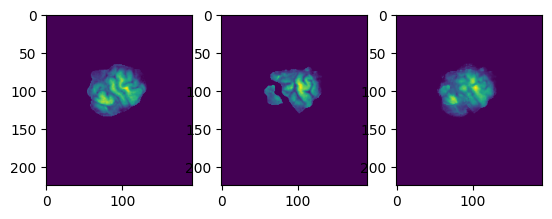

Step 200 loss [-0.837251723] lncc [-0.872388065] bending [0.0351363532] mse 0.00542189324096633


<Figure size 640x480 with 0 Axes>

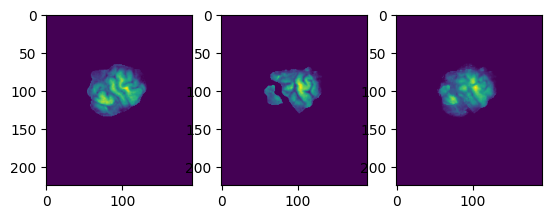

Step 250 loss [-0.84875983] lncc [-0.887763083] bending [0.0390032493] mse 0.0046697662130901


<Figure size 640x480 with 0 Axes>

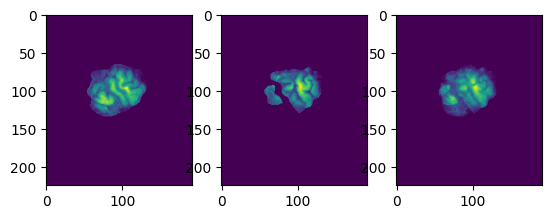

Step 0 loss [-0.722517371] lncc [-0.72252] bending [2.62428853e-06] mse 0.009571226621127598


<Figure size 640x480 with 0 Axes>

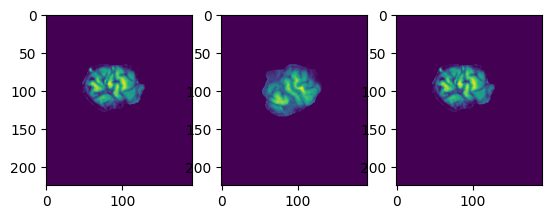

Step 50 loss [-0.770639837] lncc [-0.78249681] bending [0.0118569946] mse 0.007337077819358272


<Figure size 640x480 with 0 Axes>

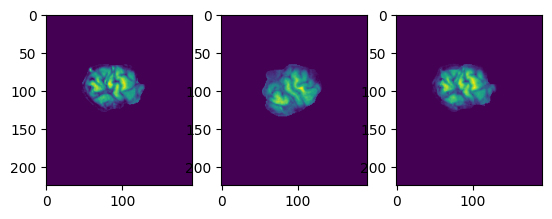

Step 100 loss [-0.803619385] lncc [-0.827337086] bending [0.0237177182] mse 0.00552373364393278


<Figure size 640x480 with 0 Axes>

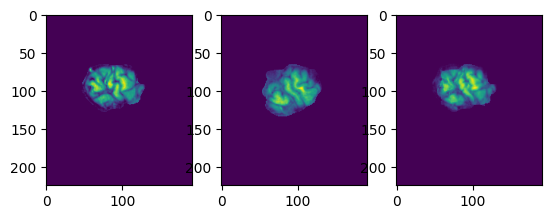

Step 150 loss [-0.826775491] lncc [-0.859483898] bending [0.0327083953] mse 0.00423482847455649


<Figure size 640x480 with 0 Axes>

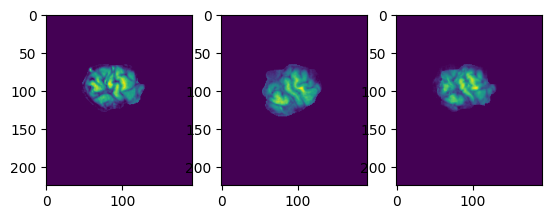

Step 200 loss [-0.8428213] lncc [-0.881698251] bending [0.0388769694] mse 0.0033649309821471825


<Figure size 640x480 with 0 Axes>

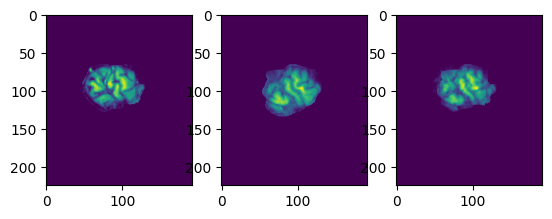

Step 250 loss [-0.853902042] lncc [-0.89672941] bending [0.0428273715] mse 0.00278509742825697


<Figure size 640x480 with 0 Axes>

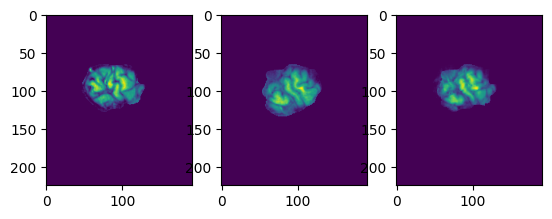

Step 0 loss [-0.730886] lncc [-0.730888605] bending [2.62611729e-06] mse 0.009162106161434954


<Figure size 640x480 with 0 Axes>

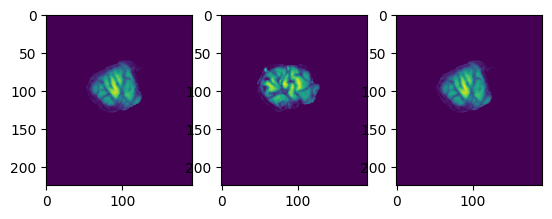

Step 50 loss [-0.781322658] lncc [-0.793247938] bending [0.0119252782] mse 0.007091306444930498


<Figure size 640x480 with 0 Axes>

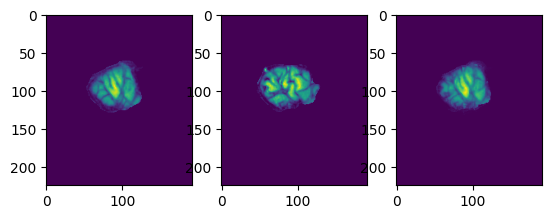

Step 100 loss [-0.813963] lncc [-0.836526573] bending [0.0225635543] mse 0.005467195279643071


<Figure size 640x480 with 0 Axes>

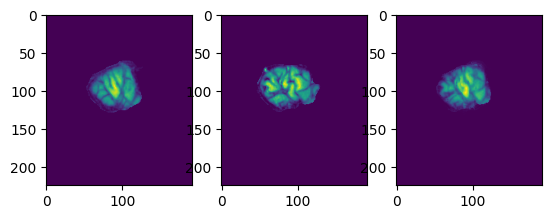

Step 150 loss [-0.83658582] lncc [-0.86716032] bending [0.0305744801] mse 0.0043218120186521965


<Figure size 640x480 with 0 Axes>

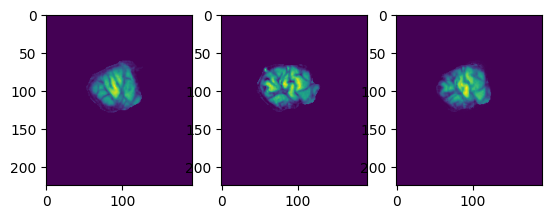

Step 200 loss [-0.85209024] lncc [-0.88791436] bending [0.0358241051] mse 0.0035523548315385327


<Figure size 640x480 with 0 Axes>

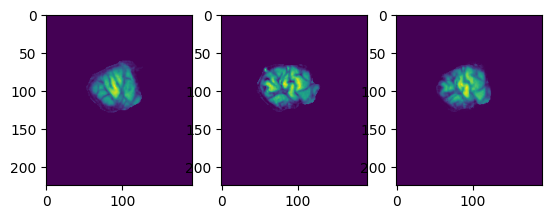

Step 250 loss [-0.86283493] lncc [-0.901803136] bending [0.0389682166] mse 0.003039605918018093


<Figure size 640x480 with 0 Axes>

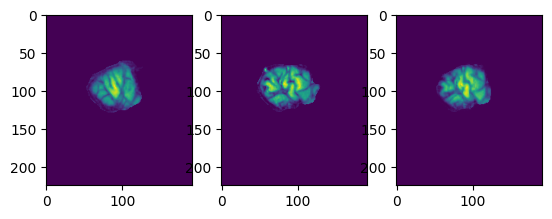

Step 0 loss [-0.724845648] lncc [-0.72484827] bending [2.62342792e-06] mse 0.014305781266826457


<Figure size 640x480 with 0 Axes>

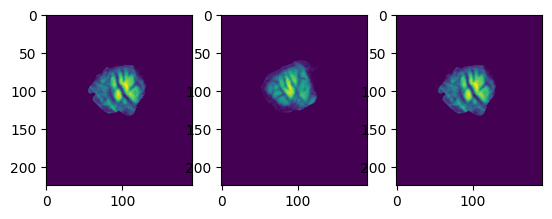

Step 50 loss [-0.763311863] lncc [-0.772559583] bending [0.00924773794] mse 0.01220713240666538


<Figure size 640x480 with 0 Axes>

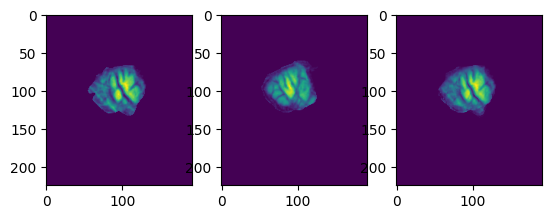

Step 100 loss [-0.790132582] lncc [-0.808693588] bending [0.0185610112] mse 0.010411585291756707


<Figure size 640x480 with 0 Axes>

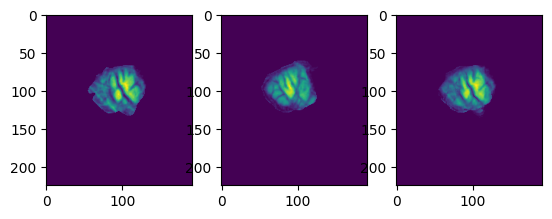

Step 150 loss [-0.809197187] lncc [-0.83481431] bending [0.0256171133] mse 0.009015661331648673


<Figure size 640x480 with 0 Axes>

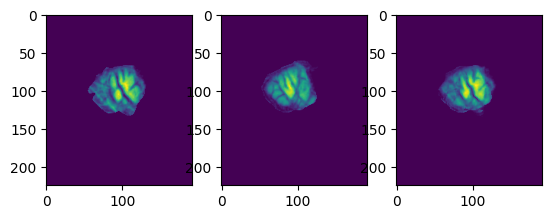

Step 200 loss [-0.823196828] lncc [-0.853735864] bending [0.0305390302] mse 0.007877651617101343


<Figure size 640x480 with 0 Axes>

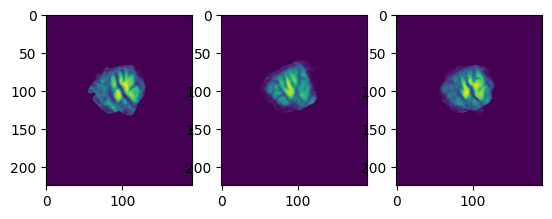

Step 250 loss [-0.834062219] lncc [-0.86810708] bending [0.0340448767] mse 0.00692860262127629


<Figure size 640x480 with 0 Axes>

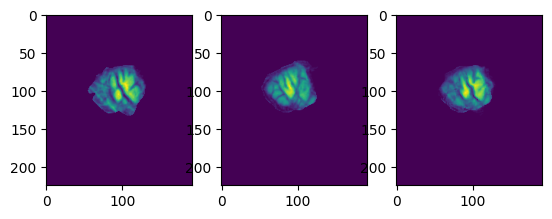

Step 0 loss [-0.73466] lncc [-0.734662652] bending [2.62353092e-06] mse 0.013488689319827574


<Figure size 640x480 with 0 Axes>

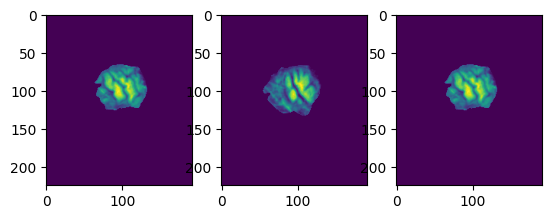

Step 50 loss [-0.774511516] lncc [-0.783356786] bending [0.00884529] mse 0.01101263126017934


<Figure size 640x480 with 0 Axes>

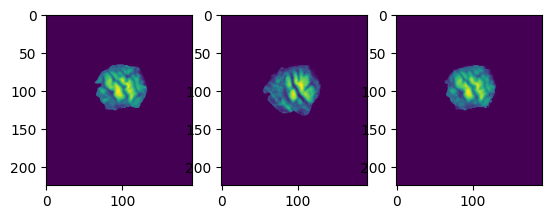

Step 100 loss [-0.804065287] lncc [-0.822179377] bending [0.0181140937] mse 0.008921301793409652


<Figure size 640x480 with 0 Axes>

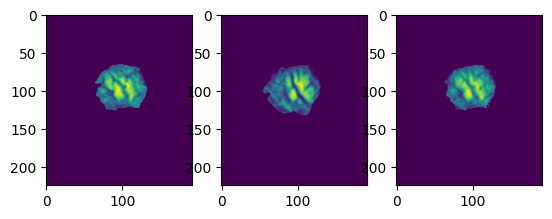

Step 150 loss [-0.825044453] lncc [-0.850068808] bending [0.0250243414] mse 0.0073913261924603195


<Figure size 640x480 with 0 Axes>

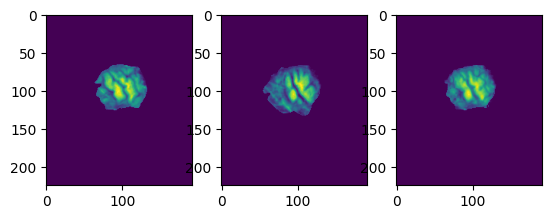

Step 200 loss [-0.839661837] lncc [-0.869193316] bending [0.0295314603] mse 0.006278782608950337


<Figure size 640x480 with 0 Axes>

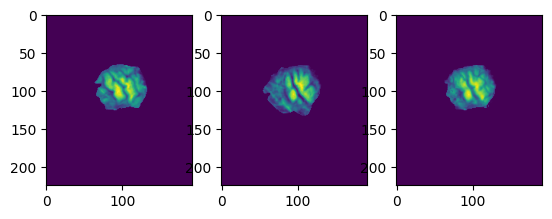

Step 250 loss [-0.850116134] lncc [-0.882488787] bending [0.032372646] mse 0.005450300788868949


<Figure size 640x480 with 0 Axes>

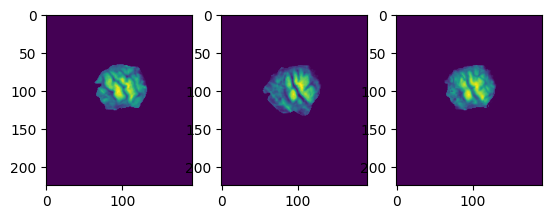

Step 0 loss [-0.742977798] lncc [-0.742980421] bending [2.6240366e-06] mse 0.011835653966968711


<Figure size 640x480 with 0 Axes>

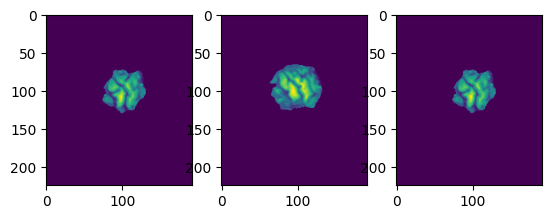

Step 50 loss [-0.78291595] lncc [-0.7920506] bending [0.00913464] mse 0.009391779170008182


<Figure size 640x480 with 0 Axes>

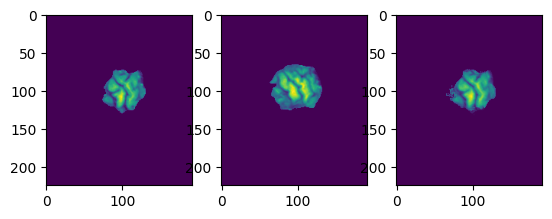

Step 100 loss [-0.812526643] lncc [-0.831317842] bending [0.0187912192] mse 0.007389839725077463


<Figure size 640x480 with 0 Axes>

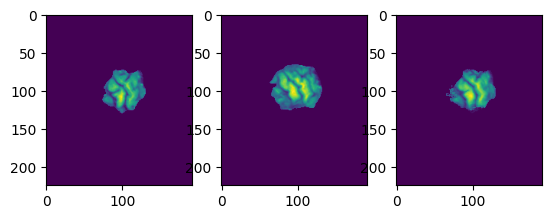

Step 150 loss [-0.83356297] lncc [-0.859517932] bending [0.0259549599] mse 0.005948432206912899


<Figure size 640x480 with 0 Axes>

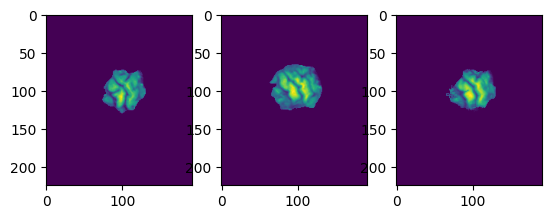

Step 200 loss [-0.848176301] lncc [-0.878898263] bending [0.0307219625] mse 0.004931259806880517


<Figure size 640x480 with 0 Axes>

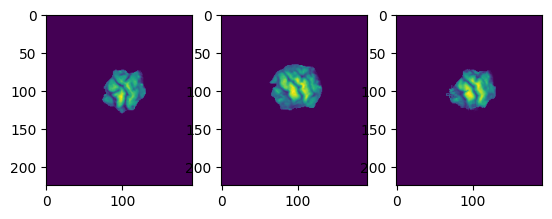

Step 250 loss [-0.858470201] lncc [-0.892394423] bending [0.0339242332] mse 0.004205555945988234


<Figure size 640x480 with 0 Axes>

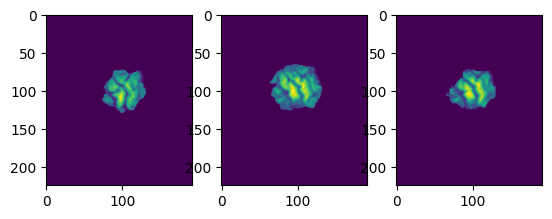

Step 0 loss [-0.729074478] lncc [-0.729077101] bending [2.62552635e-06] mse 0.011764030248142167


<Figure size 640x480 with 0 Axes>

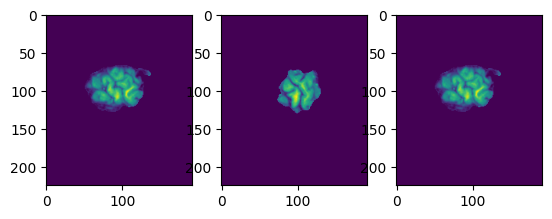

Step 50 loss [-0.771739542] lncc [-0.782322347] bending [0.0105827879] mse 0.009642134991184655


<Figure size 640x480 with 0 Axes>

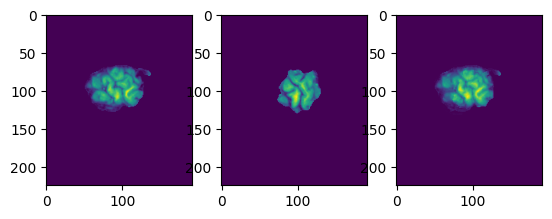

Step 100 loss [-0.804137647] lncc [-0.826179385] bending [0.0220417511] mse 0.00786831896940052


<Figure size 640x480 with 0 Axes>

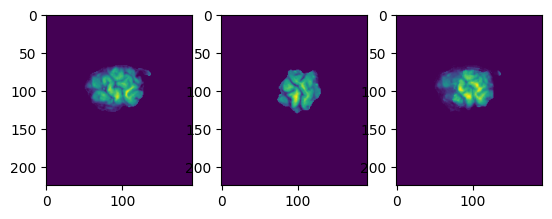

Step 150 loss [-0.826846778] lncc [-0.857071698] bending [0.0302249044] mse 0.006578803590645771


<Figure size 640x480 with 0 Axes>

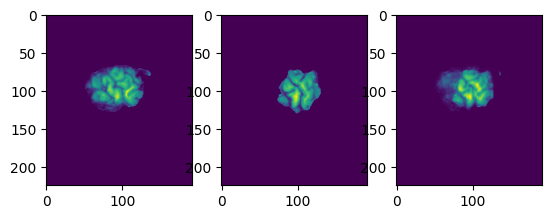

Step 200 loss [-0.842734158] lncc [-0.878288567] bending [0.0355543904] mse 0.005655010889307772


<Figure size 640x480 with 0 Axes>

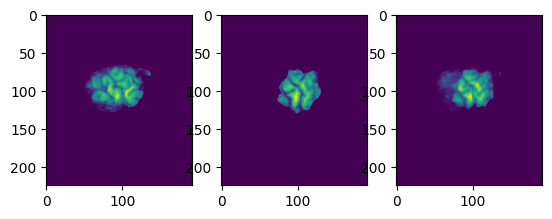

Step 250 loss [-0.854133] lncc [-0.893108845] bending [0.0389758162] mse 0.004994635830053422


<Figure size 640x480 with 0 Axes>

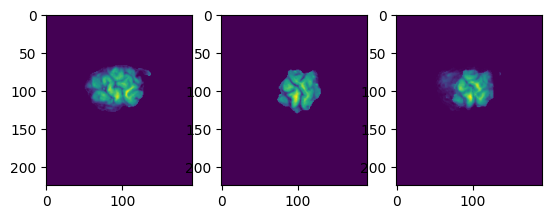

Step 0 loss [-0.722381651] lncc [-0.722384274] bending [2.62458548e-06] mse 0.009459856669003813


<Figure size 640x480 with 0 Axes>

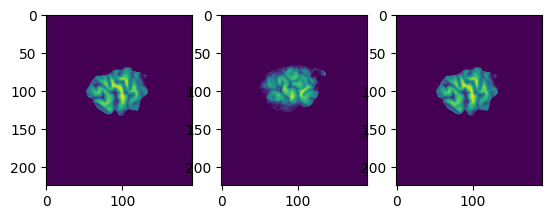

Step 50 loss [-0.763597727] lncc [-0.773178101] bending [0.00958040077] mse 0.007279491310669202


<Figure size 640x480 with 0 Axes>

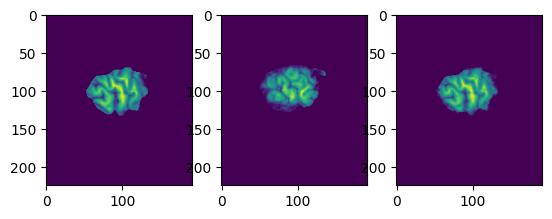

Step 100 loss [-0.79532057] lncc [-0.816088438] bending [0.0207678508] mse 0.005470292919431961


<Figure size 640x480 with 0 Axes>

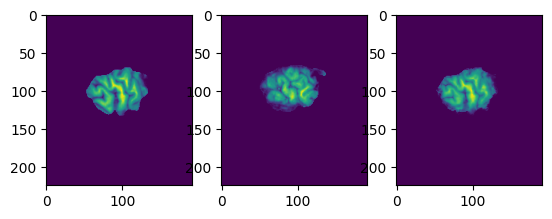

Step 150 loss [-0.818390369] lncc [-0.848128259] bending [0.0297378618] mse 0.0041856843125175685


<Figure size 640x480 with 0 Axes>

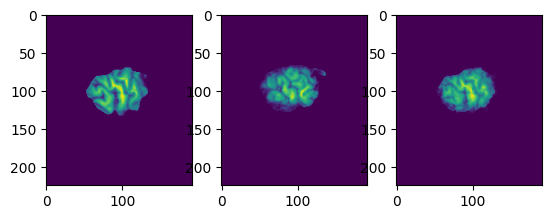

Step 200 loss [-0.834341407] lncc [-0.870087206] bending [0.0357457958] mse 0.003351156756404207


<Figure size 640x480 with 0 Axes>

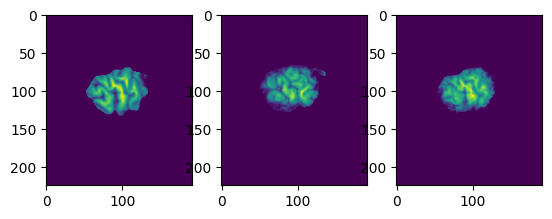

Step 250 loss [-0.845229] lncc [-0.884662151] bending [0.0394331] mse 0.00281008159521373


<Figure size 640x480 with 0 Axes>

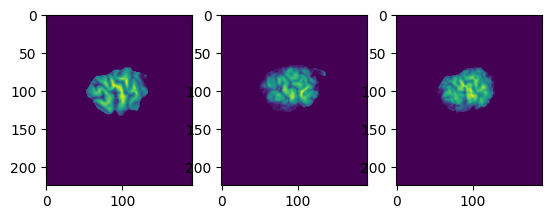

Step 0 loss [-0.721426249] lncc [-0.721428871] bending [2.62339927e-06] mse 0.01001929168434464


<Figure size 640x480 with 0 Axes>

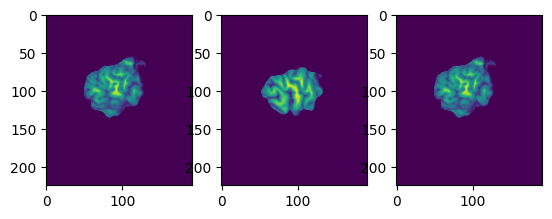

Step 50 loss [-0.765312195] lncc [-0.776609123] bending [0.0112969205] mse 0.007826497117715195


<Figure size 640x480 with 0 Axes>

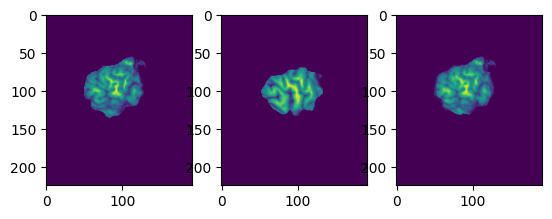

Step 100 loss [-0.796055317] lncc [-0.818730891] bending [0.022675598] mse 0.006160794283384165


<Figure size 640x480 with 0 Axes>

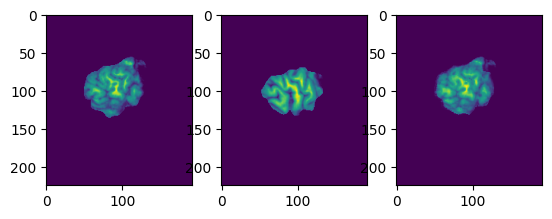

Step 150 loss [-0.8176229] lncc [-0.848834813] bending [0.0312119182] mse 0.004989500551413461


<Figure size 640x480 with 0 Axes>

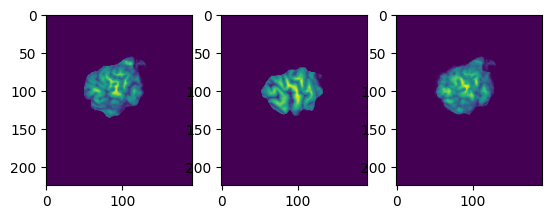

Step 200 loss [-0.832524121] lncc [-0.869369745] bending [0.0368456133] mse 0.004171954353424256


<Figure size 640x480 with 0 Axes>

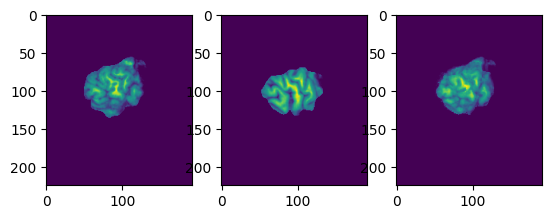

Step 250 loss [-0.842935145] lncc [-0.883398592] bending [0.0404634587] mse 0.0035986765120455382


<Figure size 640x480 with 0 Axes>

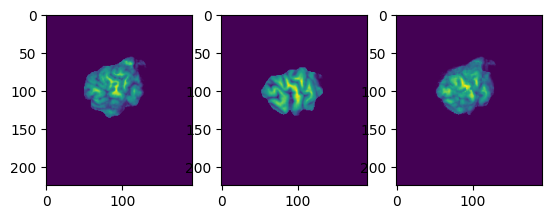

Step 0 loss [-0.722565293] lncc [-0.722567916] bending [2.62542858e-06] mse 0.011947385033893676


<Figure size 640x480 with 0 Axes>

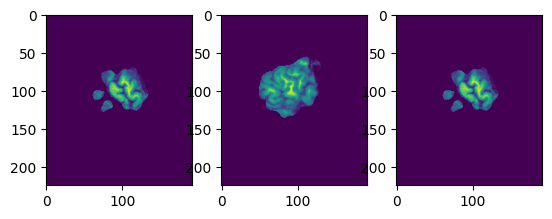

Step 50 loss [-0.7638129] lncc [-0.77512455] bending [0.0113116754] mse 0.00941117667584357


<Figure size 640x480 with 0 Axes>

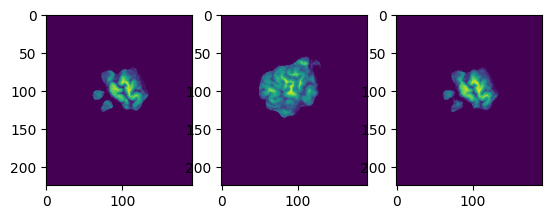

Step 100 loss [-0.793353498] lncc [-0.816369355] bending [0.0230158847] mse 0.007441886097198407


<Figure size 640x480 with 0 Axes>

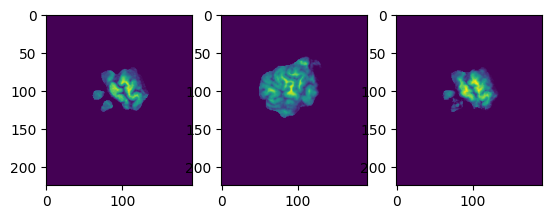

Step 150 loss [-0.813336313] lncc [-0.844798744] bending [0.0314624347] mse 0.006076254786975874


<Figure size 640x480 with 0 Axes>

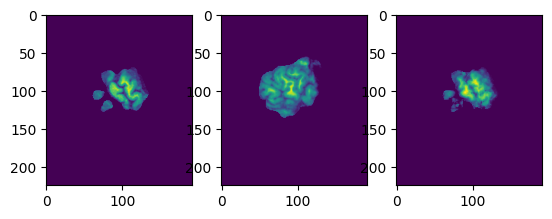

Step 200 loss [-0.826716661] lncc [-0.863730311] bending [0.0370136797] mse 0.005133144813402889


<Figure size 640x480 with 0 Axes>

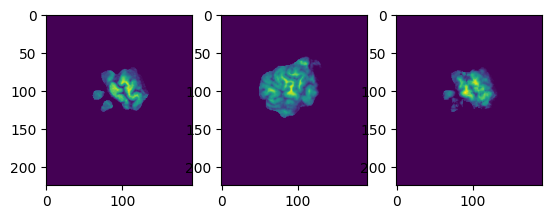

Step 250 loss [-0.836143911] lncc [-0.876976728] bending [0.040832825] mse 0.004445732937279445


<Figure size 640x480 with 0 Axes>

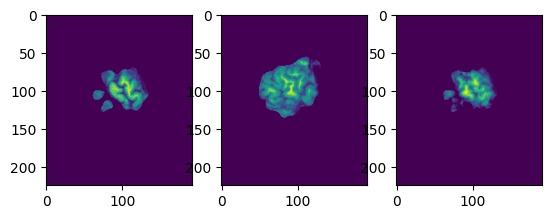

Step 0 loss [-0.737988055] lncc [-0.737990677] bending [2.62498702e-06] mse 0.01064211903001976


<Figure size 640x480 with 0 Axes>

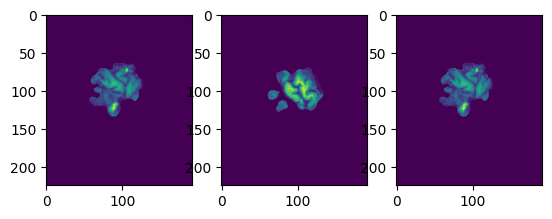

Step 50 loss [-0.785635114] lncc [-0.798148453] bending [0.0125133581] mse 0.007895646609805868


<Figure size 640x480 with 0 Axes>

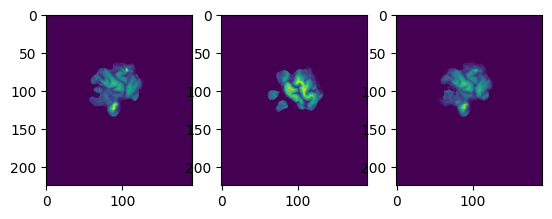

Step 100 loss [-0.817604959] lncc [-0.842157125] bending [0.0245521646] mse 0.005921395249827651


<Figure size 640x480 with 0 Axes>

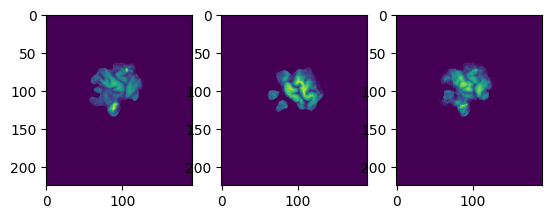

Step 150 loss [-0.838324368] lncc [-0.871106267] bending [0.0327818953] mse 0.004594966330162139


<Figure size 640x480 with 0 Axes>

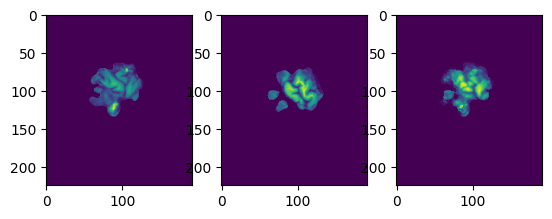

Step 200 loss [-0.85176903] lncc [-0.889669895] bending [0.0379008465] mse 0.0037214730584357197


<Figure size 640x480 with 0 Axes>

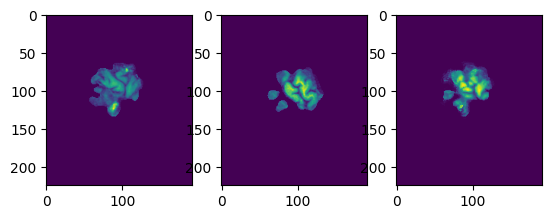

Step 250 loss [-0.860696256] lncc [-0.901631594] bending [0.0409353226] mse 0.0031406690619125077


<Figure size 640x480 with 0 Axes>

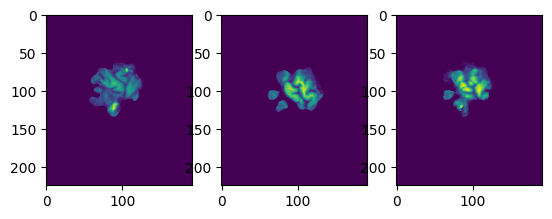

Step 0 loss [-0.732995689] lncc [-0.732998312] bending [2.62534445e-06] mse 0.011258896117404138


<Figure size 640x480 with 0 Axes>

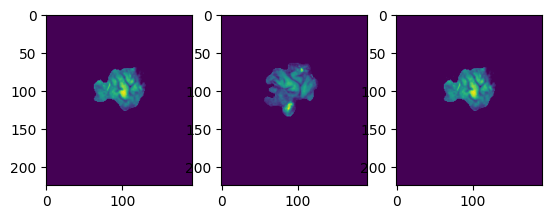

Step 50 loss [-0.773124278] lncc [-0.783073187] bending [0.00994890835] mse 0.008899767399528856


<Figure size 640x480 with 0 Axes>

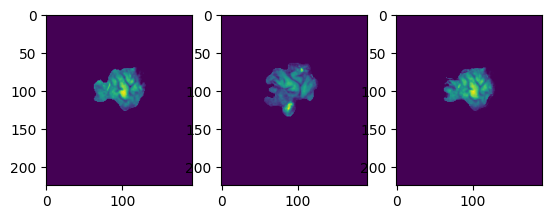

Step 100 loss [-0.802027762] lncc [-0.822547197] bending [0.0205194075] mse 0.007029236306686503


<Figure size 640x480 with 0 Axes>

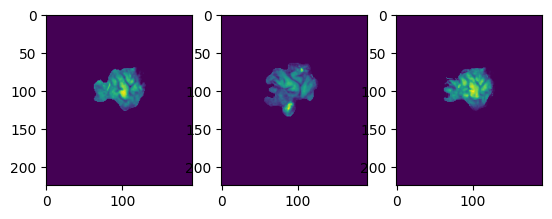

Step 150 loss [-0.822549] lncc [-0.851181] bending [0.0286319777] mse 0.0056905561012562545


<Figure size 640x480 with 0 Axes>

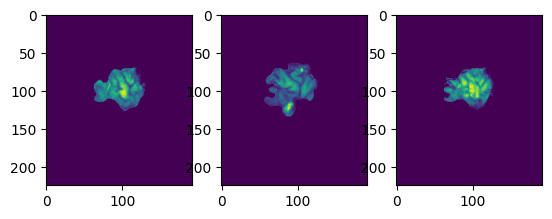

Step 200 loss [-0.836856246] lncc [-0.871194899] bending [0.0343386456] mse 0.004763151649414506


<Figure size 640x480 with 0 Axes>

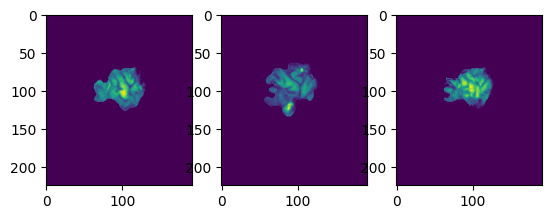

Step 250 loss [-0.846876085] lncc [-0.884930432] bending [0.0380543731] mse 0.00412545629942779


<Figure size 640x480 with 0 Axes>

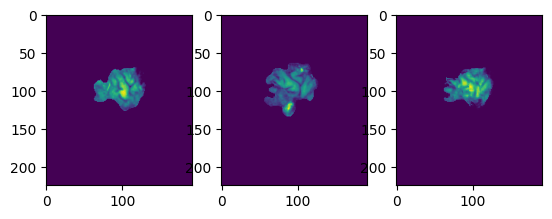

Step 0 loss [-0.740038931] lncc [-0.740041554] bending [2.6244511e-06] mse 0.010466835361938539


<Figure size 640x480 with 0 Axes>

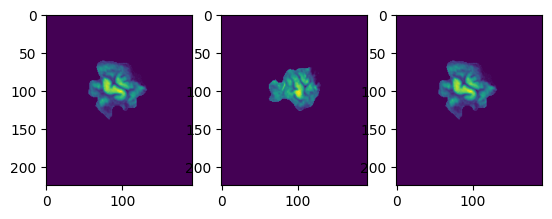

Step 50 loss [-0.785191119] lncc [-0.796496391] bending [0.0113052819] mse 0.008144068183764765


<Figure size 640x480 with 0 Axes>

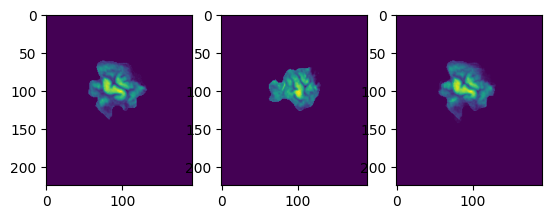

Step 100 loss [-0.817171872] lncc [-0.840500414] bending [0.0233285483] mse 0.006240437292681494


<Figure size 640x480 with 0 Axes>

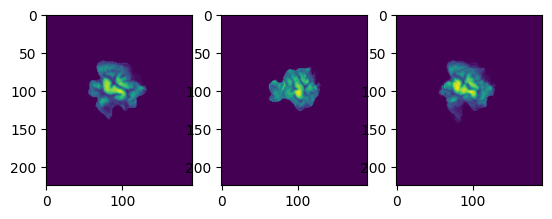

Step 150 loss [-0.838564038] lncc [-0.870396197] bending [0.0318321548] mse 0.0049057343698004656


<Figure size 640x480 with 0 Axes>

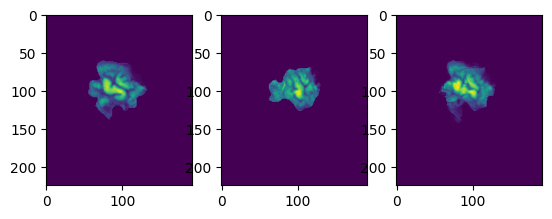

Step 200 loss [-0.852817953] lncc [-0.890158] bending [0.0373400226] mse 0.003965958589257172


<Figure size 640x480 with 0 Axes>

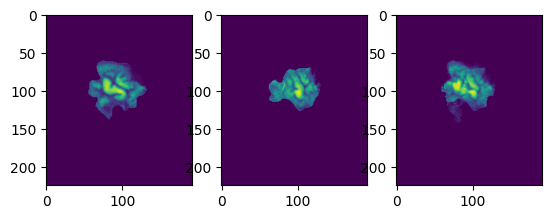

Step 250 loss [-0.862498] lncc [-0.903277636] bending [0.0407796763] mse 0.003300312943909741


<Figure size 640x480 with 0 Axes>

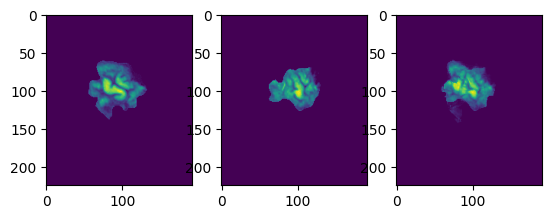

Step 0 loss [-0.730353773] lncc [-0.730356395] bending [2.62552021e-06] mse 0.01092174310724751


<Figure size 640x480 with 0 Axes>

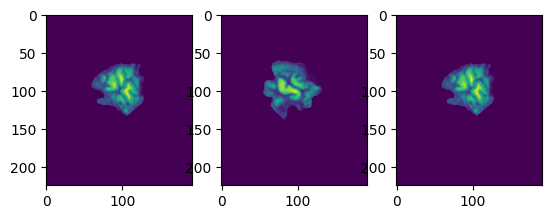

Step 50 loss [-0.773305655] lncc [-0.784172654] bending [0.0108670164] mse 0.008803279191438517


<Figure size 640x480 with 0 Axes>

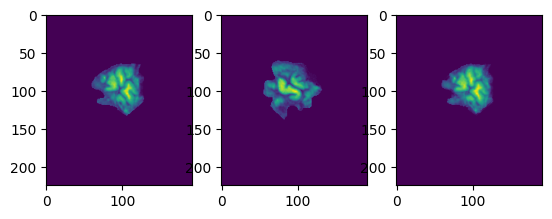

Step 100 loss [-0.804885507] lncc [-0.827064] bending [0.0221784506] mse 0.006996446912634947


<Figure size 640x480 with 0 Axes>

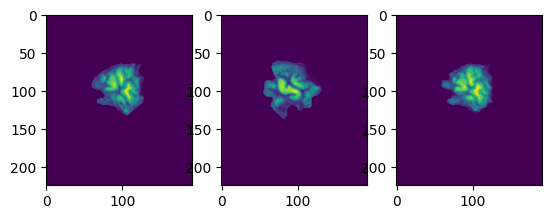

Step 150 loss [-0.827113092] lncc [-0.857786894] bending [0.0306738298] mse 0.00569033716385062


<Figure size 640x480 with 0 Axes>

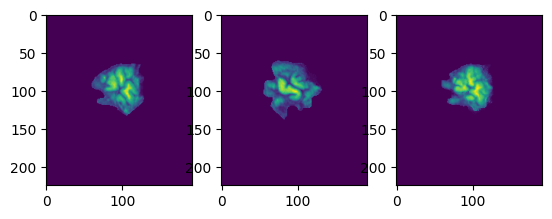

Step 200 loss [-0.842318654] lncc [-0.878481567] bending [0.0361629091] mse 0.0047863978150728724


<Figure size 640x480 with 0 Axes>

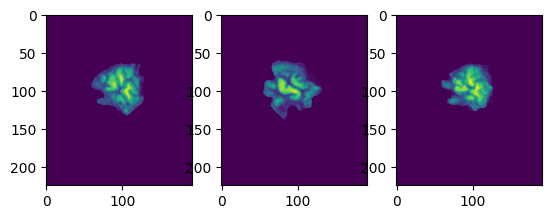

Step 250 loss [-0.852915347] lncc [-0.892375886] bending [0.0394605398] mse 0.004143895072375585


<Figure size 640x480 with 0 Axes>

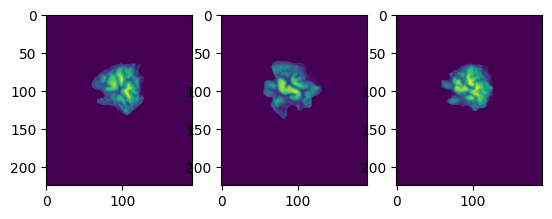

Step 0 loss [-0.728243113] lncc [-0.728245735] bending [2.62552953e-06] mse 0.009962134365791839


<Figure size 640x480 with 0 Axes>

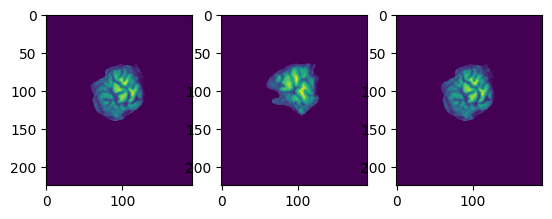

Step 50 loss [-0.778509676] lncc [-0.79120481] bending [0.0126951179] mse 0.007474853860178376


<Figure size 640x480 with 0 Axes>

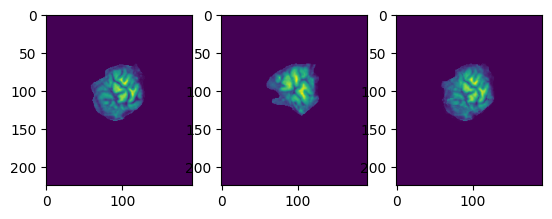

Step 100 loss [-0.813398659] lncc [-0.83900696] bending [0.0256083291] mse 0.005485615616867941


<Figure size 640x480 with 0 Axes>

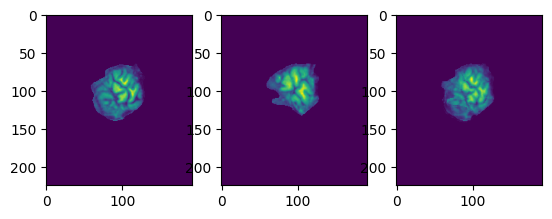

Step 150 loss [-0.836403668] lncc [-0.870821476] bending [0.0344178267] mse 0.004135492458363736


<Figure size 640x480 with 0 Axes>

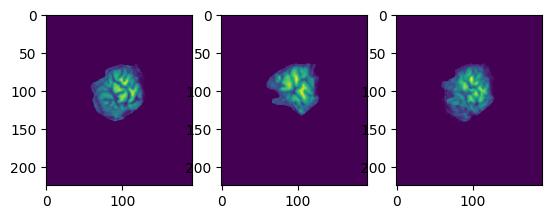

Step 200 loss [-0.851390541] lncc [-0.891170561] bending [0.0397800393] mse 0.0032582410200254117


<Figure size 640x480 with 0 Axes>

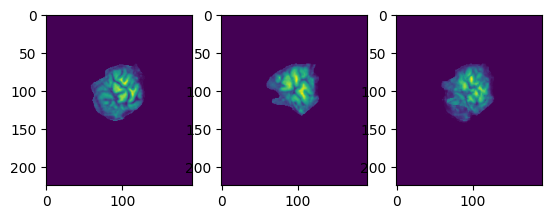

Step 250 loss [-0.861330688] lncc [-0.904239237] bending [0.0429085642] mse 0.00268490833492359


<Figure size 640x480 with 0 Axes>

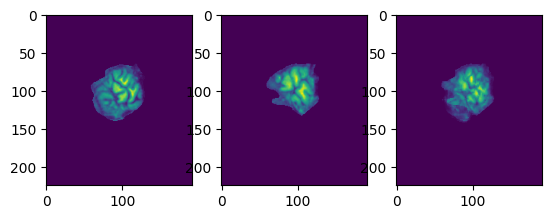

Step 0 loss [-0.727483034] lncc [-0.727485657] bending [2.62624303e-06] mse 0.01144885868119531


<Figure size 640x480 with 0 Axes>

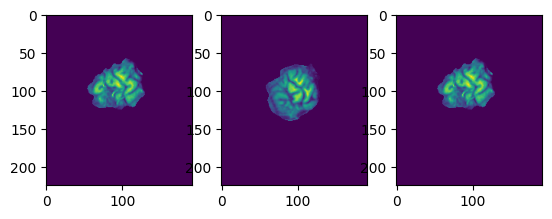

Step 50 loss [-0.769743443] lncc [-0.780032575] bending [0.0102891261] mse 0.008989406773618815


<Figure size 640x480 with 0 Axes>

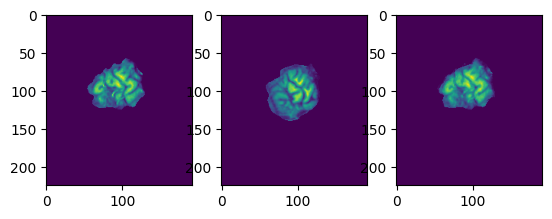

Step 100 loss [-0.799827099] lncc [-0.820355237] bending [0.0205281656] mse 0.007072307197228986


<Figure size 640x480 with 0 Axes>

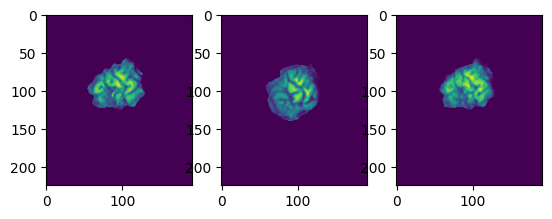

Step 150 loss [-0.820601583] lncc [-0.848585427] bending [0.0279838331] mse 0.005678705864430948


<Figure size 640x480 with 0 Axes>

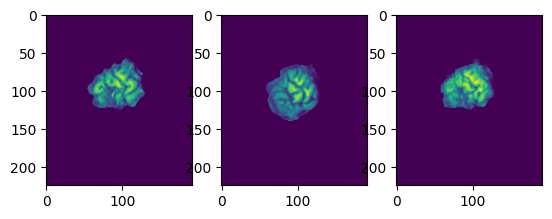

Step 200 loss [-0.835047424] lncc [-0.868120313] bending [0.0330728628] mse 0.004675514488024536


<Figure size 640x480 with 0 Axes>

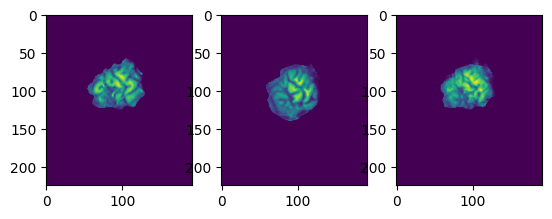

Step 250 loss [-0.845161736] lncc [-0.881440401] bending [0.0362786651] mse 0.0039582087862201345


<Figure size 640x480 with 0 Axes>

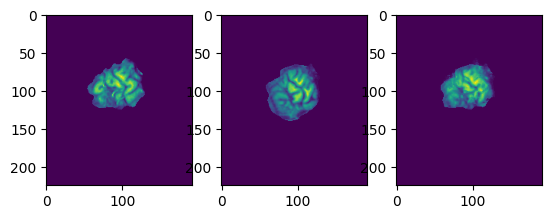

In [8]:
for _, pair in pairs_df.iterrows():
    fixed_id = pair[0]
    fixed_id_l.append(fixed_id)
    moving_id = pair[1]
    moving_id_l.append(moving_id)
    fixed_image_path = os.path.join(data_folder, f'OASIS_OAS1_0{fixed_id}_MR1/aligned_norm.nii.gz')
    # print('fixed', fixed_image_path)
    moving_image_path = os.path.join(data_folder, f'OASIS_OAS1_0{moving_id}_MR1/aligned_norm.nii.gz')
    # print('moving', moving_image_path)

    fix_image = sitk.ReadImage(fixed_image_path)
    mov_image = sitk.ReadImage(moving_image_path)

    array_fix = sitk.GetArrayFromImage(fix_image)
    array_mov = sitk.GetArrayFromImage(mov_image)

    fixed_image = tf.constant(array_fix)
    moving_image = tf.constant(array_mov)

    moving_image = tf.expand_dims(moving_image, axis=0)
    fixed_image = tf.expand_dims(fixed_image, axis=0)

    fixed_seg_path = os.path.join(data_folder, f'OASIS_OAS1_0{fixed_id}_MR1/aligned_seg35.nii.gz')
    moving_seg_path = os.path.join(data_folder, f'OASIS_OAS1_0{moving_id}_MR1/aligned_seg35.nii.gz')

    fix_seg = sitk.ReadImage(fixed_seg_path)
    mov_seg = sitk.ReadImage(moving_seg_path)

    array_fix_seg = sitk.GetArrayFromImage(fix_seg)
    array_mov_seg = sitk.GetArrayFromImage(mov_seg)

    fixed_image_seg = tf.constant(array_fix_seg)
    moving_image_seg = tf.constant(array_mov_seg)

    moving_image_seg = tf.expand_dims(moving_image_seg, axis=0)
    fixed_image_seg = tf.expand_dims(fixed_image_seg, axis=0)

    moving_image_seg = tf.cast(moving_image_seg, dtype=tf.float32)
    fixed_image_seg = tf.cast(fixed_image_seg, dtype=tf.float32)


    # We initialise our layers
    fixed_image_size = fixed_image.shape
    initialiser = tf.random_normal_initializer(mean=0, stddev=1e-3)

    # Creating our DDF tensor that can be trained
    # The DDF will be of shape [IM_SIZE_1, IM_SIZE_2, 3],
    # representing the displacement field at each pixel and xyz dimension.
    var_ddf = tf.Variable(initialiser([1, fixed_image_size[1], fixed_image_size[2], fixed_image_size[3], 3]), name="ddf", trainable=True)
    # var_ddf = tf.Variable(initialiser(fixed_image_size), name="ddf", trainable=True)

    # We create a warping layer and initialise an optimizer
    warping = layer.Warping(fixed_image_size=fixed_image_size[1:4] + (1,))
    optimiser = tf.optimizers.Adam(learning_rate)

    ## Optimising the layer
    ## With GPU this takes about 5 minutes.
    for step in range(total_iter):
        # Call the gradient tape function
  
        loss_opt, loss_image_opt, loss_deform_opt, mse, dice = train_step(
            warping, var_ddf, optimiser, moving_image, fixed_image, moving_image_seg, fixed_image_seg, 35)

        # Append ddf
        if (step % 50) == 0:  # print info at every 50th step
            tf.print(
                "Step",
                step,
                "loss",
                loss_opt,
                image_loss_name,
                loss_image_opt,
                deform_loss_name,
                loss_deform_opt, 'mse', mse,
                'dice', dice
            )
            
            plt.figure()
            fig, axs = plt.subplots(1, 3)
            warped_moving_image = warping(inputs=[var_ddf, moving_image])
            axs[0].imshow(moving_image[0, ..., 12])
            axs[1].imshow(fixed_image[0, ..., 12])
            axs[2].imshow(warped_moving_image[0, ..., 12])
            plt.show()

    deformation_fields.append(var_ddf)

In [10]:
deformation_fields_np = []
for ddf in deformation_fields:
  np_ddf = ddf.numpy()
  ddf_reshape = np_ddf.T[..., 0]
  resized_array = ddf_reshape[:, ::2, ::2, ::2]
  resized_array = resized_array.astype(np.float16)
  deformation_fields_np.append(resized_array)

In [11]:
output_folder = os.path.join(data_folder, 'Displacement_Fields_deepreg3')
os.makedirs(output_folder, exist_ok=True)

for i, deformation_field in enumerate(deformation_fields_np):
  output_path = os.path.join(output_folder, 'disp_0' + str(fixed_id_l[i]) + '_0' + str(moving_id_l[i]) + '.npz')
  print(output_path)
  np.savez(output_path, deformation_field )


/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0438_0439.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0439_0440.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0440_0441.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0441_0442.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0442_0443.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0443_0444.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0444_0445.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0445_0446.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0446_0447.npz
/content/drive/MyDrive/Learn2Reg/OASIS/data/OASIS/Displacement_Fields_deepreg3/disp_0447_0448.npz
/content/drive/MyDri

In [ ]:
## Tried to make a convolutional neural network combined with classical registration. Did not work yet.


# # Define the network architecture
# class NeuralNetwork(tf.keras.Model):
#     def __init__(self, data_size):
#         super(NeuralNetwork, self).__init__()
#         self.conv1 = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')
#         self.conv2 = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense = tf.keras.layers.Dense(128, activation='relu')

#         # Initialise the ddf and make the variable trainable
#         initialiser = tf.random_normal_initializer(mean=0, stddev=1e-3)
#         self.ddf = tf.Variable(initialiser([1, data_size[1], data_size[2], data_size[3], 3]), trainable=True)
        
#     def call(self, inputs):
#         # Assuming inputs is a tuple of (moving_image, fixed_image)
#         x = tf.concat(inputs, axis=-1)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.flatten(x)
#         x = self.dense(x)
#         return x


# # build neural network object
# network=NeuralNetwork(data_size)
# network.build(input_shape=(None, data_size))
# network.summary()

# loss_function = CategoricalCrossentropy(from_logits=True)
# learning_rate = 0.001 
# optimizer = Adam(learning_rate=learning_rate) 


# def train_network(model, optimizer, fixed_image, moving_image, warping, deform_loss_weight):
#   with tf.GradientTape() as tape:
#     pred = model((moving_image, fixed_image))
#     cc_loss = loss_function(y_true=fixed_image, y_pred=pred)

#     # Warp the moving image with the deformation field
#     warped_image = warping(inputs=[model.dff, moving_image])
#     # Calculating the image loss between the ground truth and prediction

#     loss_image = image_loss.dissimilarity_fn(y_true=fixed_image, y_pred=pred, name=image_loss_name)
#     # Calculate the deformation loss
#     loss_deform = deform_loss.local_displacement_energy(model.dff, deform_loss_name)
#     # Calculate the total loss with different loss functions
#     total_loss = cc_loss + loss_image + deform_loss_weight*loss_deform
  
#   # Calculate the gradients by backpropagating the loss to the trainable layer
#   gradients = tape.gradient(total_loss, model.trainable_variables)
#   # Using tf optimizer, apply the gradients
#   optimizer.apply_gradients(zip(gradients, model.trainable_variables)
#   return loss, loss_image, loss_deform, cc_loss







